<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/HysteresisDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

Getting the Dataset from the Github repository:

In [2]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

--2021-11-09 16:06:24--  https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/main/Dataset/P2_measurements.zip [following]
--2021-11-09 16:06:24--  https://raw.githubusercontent.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/main/Dataset/P2_measurements.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9358428 (8.9M) [application/zip]
Saving to: ‘P2_measurements.zip’

P2_measurements.zip 100%[===================>]   

# Reading and Plotting the Dataset
The Hysteresis Dataset is downloaded from the Github repository and stored into a dictionary.

Plots of the single Hysteresis measurements at the different input frequencies are displayed.

In [3]:
cwd = "/content/P2_measurements"

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    dataset[file] = data

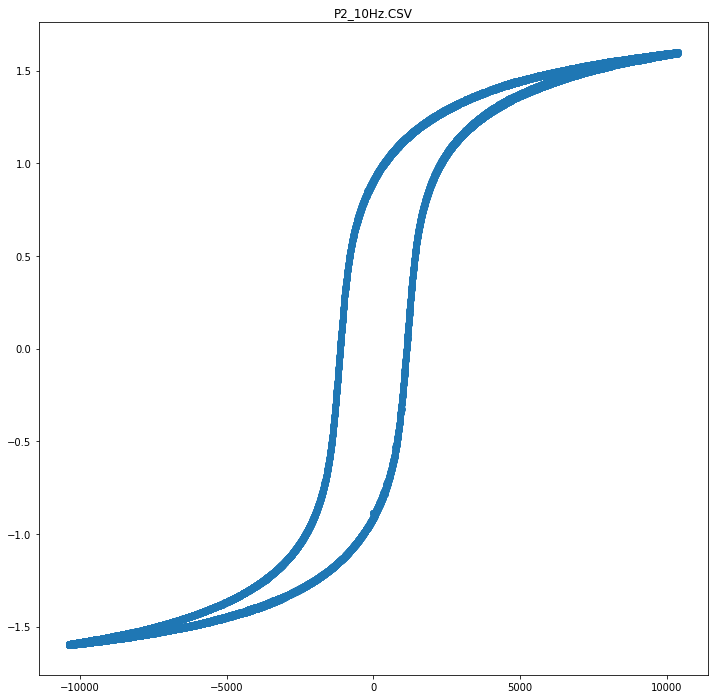

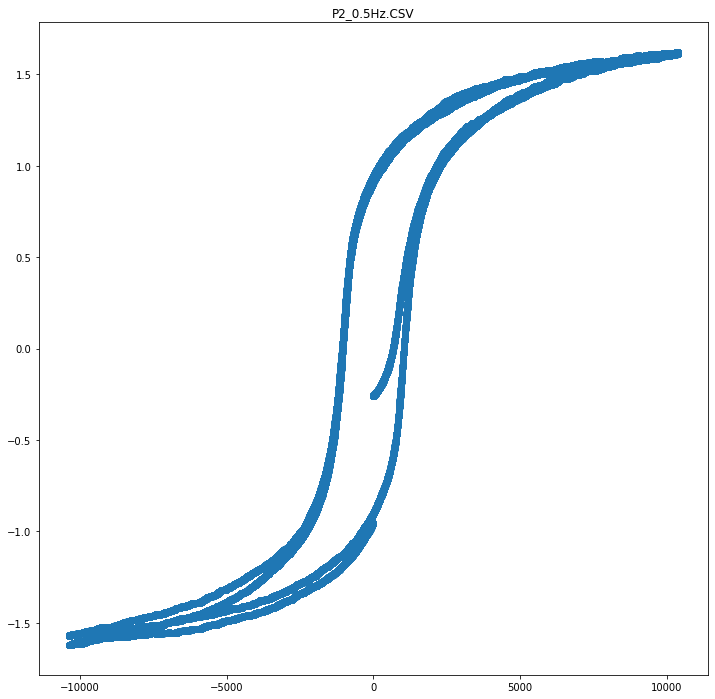

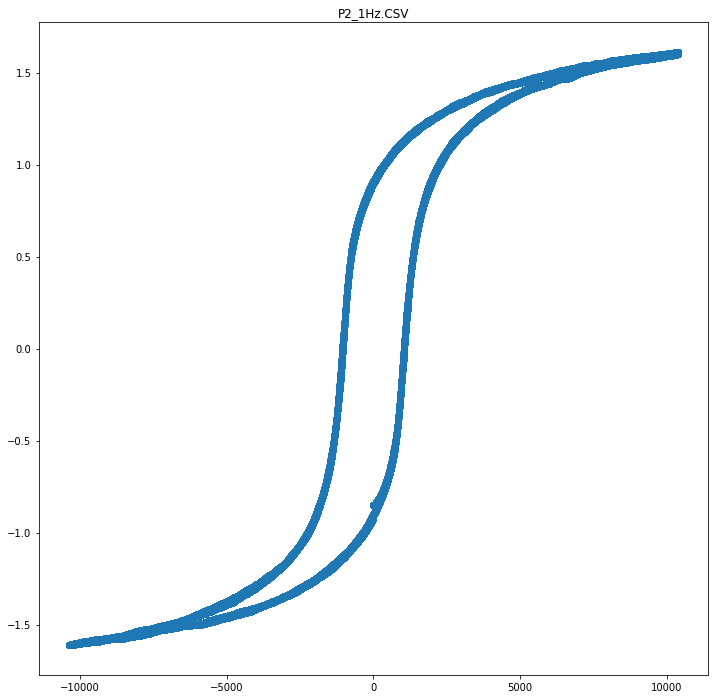

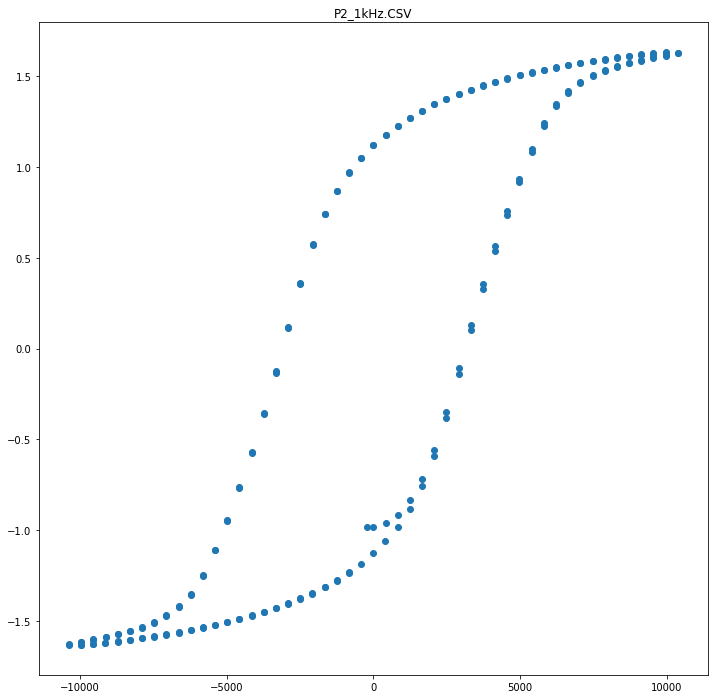

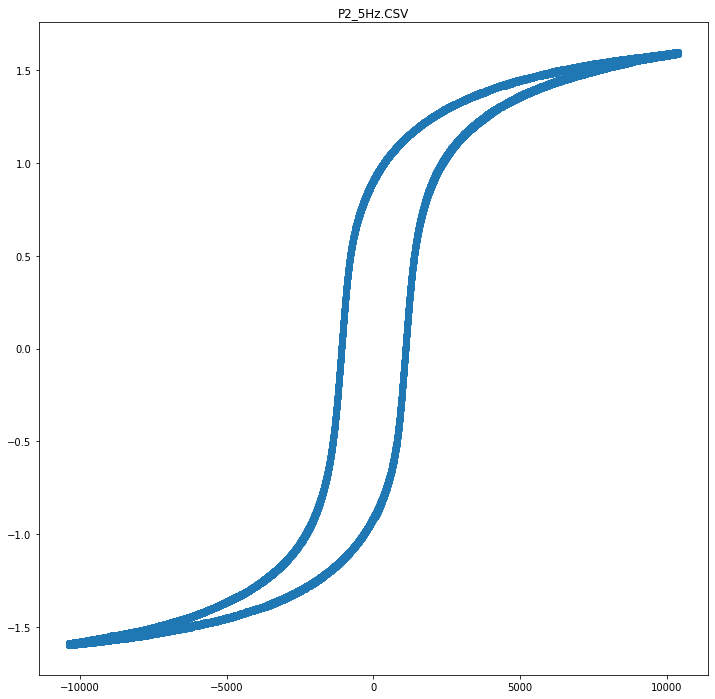

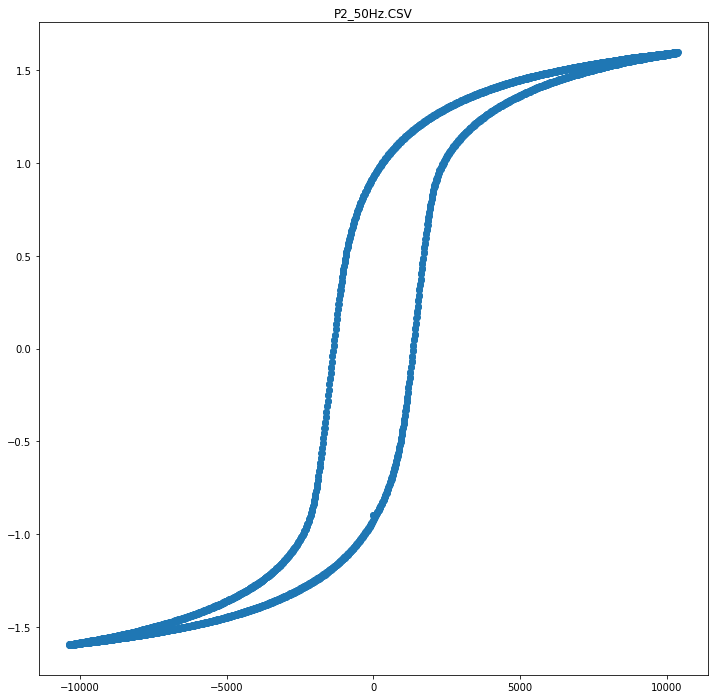

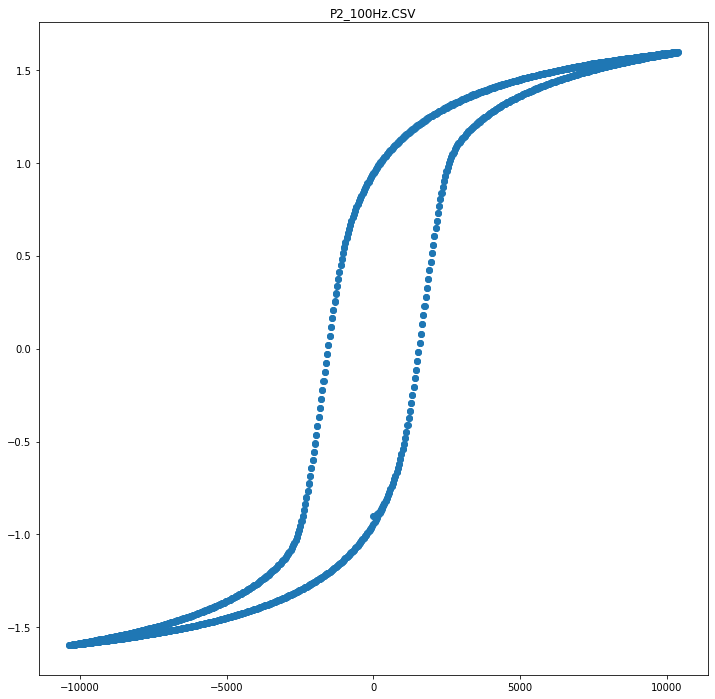

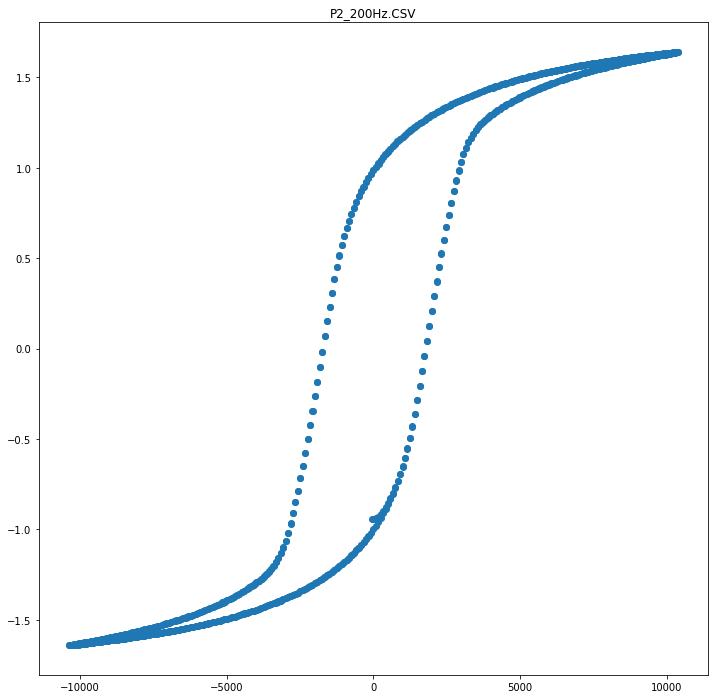

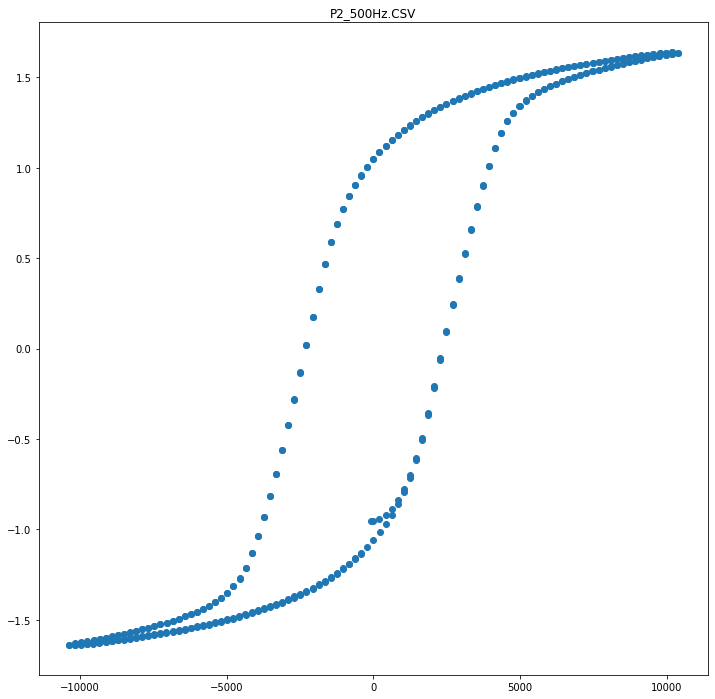

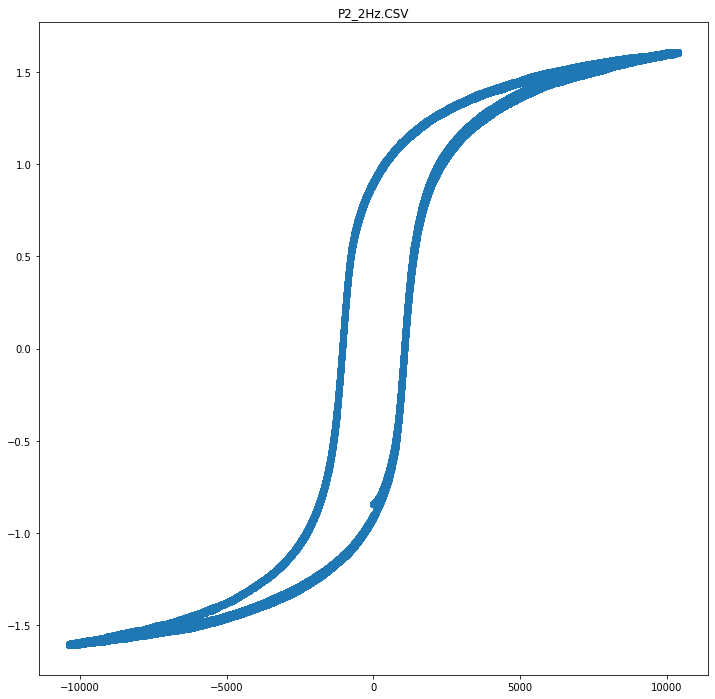

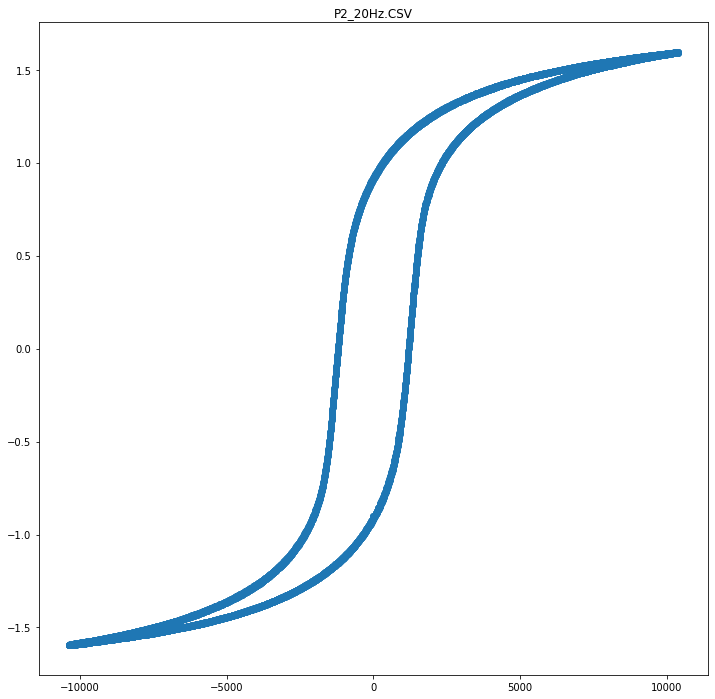

In [4]:
# Print-Loop
for el in dataset:
    # Getting the values from the Dataframe
    X = dataset[el]["H"]
    Y = dataset[el]["B"]
    
    # Plotting the values
    plt.figure(figsize=(12,12))
    plt.title(el)
    plt.scatter(X, Y)

# Preliminary experiments for Training the dRNN

Different strategies to train the dRNN are here explored, trying to understand how to proceed.

In [91]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [92]:
# Extracting one Hysteresis Measurement
X_train = np.array(dataset['P2_1Hz.CSV']['H']).reshape(-1, 1)
Y_train = np.array(dataset['P2_1Hz.CSV']['B']).reshape(-1, 1)

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (-1, 1))
scaler_y = MinMaxScaler(feature_range = (-1, 1))

# Fitting the scaler using available Training Data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(Y_train)

# Applying the scaler to Training Data
train_y_norm = output_scaler.transform(Y_train)
train_x_norm = input_scaler.transform(X_train)

In [93]:
class DiagonalRNNCell(tf.keras.layers.SimpleRNNCell):
    def __init__(self, **kwargs):
        super(DiagonalRNNCell, self).__init__(recurrent_initializer='glorot_uniform',
                                              **kwargs)
    
    # Overriding the build method 
    def build(self, input_shape):
        super(DiagonalRNNCell, self).build(input_shape)

        # Override only the recurrent kernel 
        self.recurrent_kernel = self.add_weight(
            shape=(self.units,),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

    # Overriding the call method    
    def call(self, inputs, states, training=None):
        prev_output = states[0] if tf.nest.is_nested(states) else states
        dp_mask = self.get_dropout_mask_for_cell(inputs, training)
        rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
            prev_output, training)

        if dp_mask is not None:
            h = tf.keras.backend.dot(inputs * dp_mask, self.kernel)
        else:
            h = tf.keras.backend.dot(inputs, self.kernel)
        if self.bias is not None:
            h = tf.keras.backend.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output = prev_output * rec_dp_mask
        # The Tensor product becomes a vector element-wise product
        output = h + prev_output * self.recurrent_kernel
        if self.activation is not None:
            output = self.activation(output)

        new_state = [output] if tf.nest.is_nested(states) else output
        return output, new_state

In [94]:
# Example: building a dRNN using the custom cell

cell = DiagonalRNNCell(units=256)

inputs = tf.keras.layers.Input(shape=(1, 1,), batch_size=20)
layer = tf.keras.layers.RNN(cell, stateful=True)(inputs) # To have cross-batch statefulness
outputs = tf.keras.layers.Dense(1, activation='linear')(layer)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name='dRNN')
model.summary()

Model: "dRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(20, 1, 1)]              0         
_________________________________________________________________
rnn_13 (RNN)                 (20, 256)                 768       
_________________________________________________________________
dense_13 (Dense)             (20, 1)                   257       
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

In [97]:
# Training the model for 100 epochs, resetting the states after each epoch.
for i in range(100):
    model.fit(train_x_norm, train_y_norm, epochs=1, batch_size=20, verbose=2)
    model.reset_states()

10000/10000 - 13s - loss: 0.0701 - mean_absolute_error: 0.2005
10000/10000 - 13s - loss: 0.0326 - mean_absolute_error: 0.0924
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0880
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0880
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0880
10000/10000 - 15s - loss: 0.0321 - mean_absolute_error: 0.0880
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0881
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0881
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0881
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0880
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0881
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0882
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0882
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0881
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error: 0.0881
10000/10000 - 13s - loss: 0.0321 - mean_absolute_error:

In [98]:
Y_test = model.predict(train_x_norm, batch_size=20)

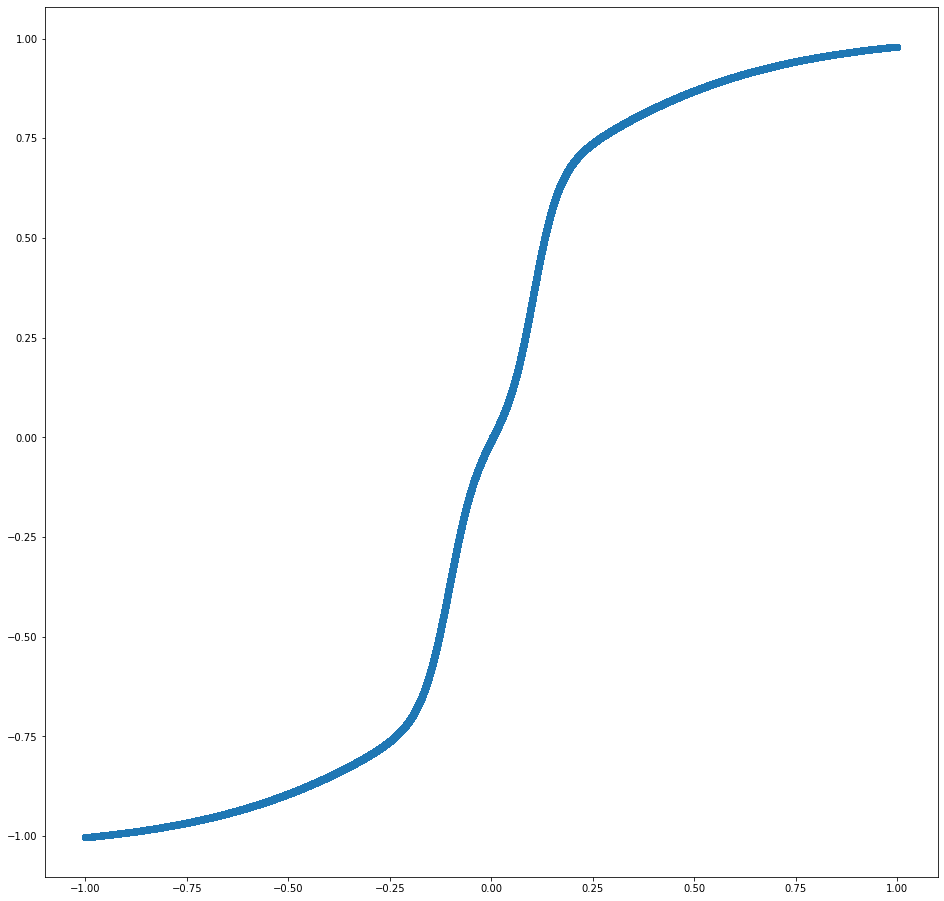

In [99]:
plt.figure(figsize=(16, 16))
plt.scatter(train_x_norm, Y_test)